In [1]:
import mido
import heapq # merge (i.e. from mergesort)
import ripser
import numpy as np
from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange as trange
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.svm import SVC
import sklearn_tda as tda
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import umap

Gudhi not found--GraphInducedComplex not available


In [2]:
mid = mido.MidiFile('data/011.mid')
msgArray = []
for i, track in enumerate(mid.tracks):
    print('Track {}: {}'.format(i, track.name))
    for msg in track:
        msgArray.append(msg)
#         print(msg)

Track 0: 
Track 1: 


In [3]:
# put together midi files 
def convertToAbsoluteTimeAndMerge(mid):
    # takes the full midi object as input
    # outputs list of pairs: [..., (abs_time, midi_message), ...]
    allEvents = []
    for i, track in enumerate(mid.tracks):
        allEvents.append([])
        abs_time = 0
        for msg in track:
            abs_time = abs_time + msg.time
            if msg.type == 'note_on' and msg.velocity > 0:
                allEvents[i].append((abs_time, msg))

    return list(heapq.merge(*allEvents, key=lambda x: x[0]))

In [4]:
# return one dimensional point cloud -> n nodes
def ExtractSingleNotesUnique(notes, getNote=lambda x: x):
    # takes the ordered set of notes as inputs. The actual note is accessed using the getNote function
    # outputs the set of notes (modulo 12) in the midi file
    noteSet = set()
    for note in notes:
        noteSet.add(getNote(note) % 12)
    return np.array(noteSet)

In [5]:
# 3D point cloud return -> note 1 note 2 note 3; note 2 note 3 note 4 -> easiest way to preserve time series. return M X N point cloud
def ExtractNotesTimeSeriesUnique(notes, N, getNote=lambda x: x):
    noteSeriesSet = set()
    for ind in range(len(notes) - N + 1):
        noteSeries = tuple(getNote(notes[ind + j]) % 12 for j in range(N))
        noteSeriesSet.add(noteSeries)
    return np.array([np.array(noteSeries) for noteSeries in noteSeriesSet])

In [6]:
# defines the distance function between every pair of points in the point cloud
def ComputeNNoteSeriesDistances(noteSeriesSet):
    dists = np.zeros((len(noteSeriesSet), len(noteSeriesSet)))
    for i in range(noteSeriesSet.shape[0]):
        for j in range(i, noteSeriesSet.shape[0]):
            v = np.abs(noteSeriesSet[i] - noteSeriesSet[j])
            diffVec = np.minimum(v, 12 - v)
            dists[i,j] = np.sum(diffVec)
            dists[j,i] = dists[i,j]
    return dists

In [7]:
mid = mido.MidiFile('data/013.mid')
notes = ExtractNotesTimeSeriesUnique(convertToAbsoluteTimeAndMerge(mid), 1, getNote=lambda x: x[1].note)
print(len(notes))
notes = ExtractNotesTimeSeriesUnique(convertToAbsoluteTimeAndMerge(mid), 2, getNote=lambda x: x[1].note)
print(len(notes))
notes = ExtractNotesTimeSeriesUnique(convertToAbsoluteTimeAndMerge(mid), 3, getNote=lambda x: x[1].note)
print(len(notes))

7
41
130


In [8]:
notes.shape

(130, 3)

In [9]:
notes[0]

array([8, 6, 6])

In [10]:
notes = ExtractNotesTimeSeriesUnique(convertToAbsoluteTimeAndMerge(mid), 3, getNote=lambda x: x[1].note)
print(len(notes))
notes[0].shape

130


(3,)

In [11]:
dists = ComputeNNoteSeriesDistances(notes)

In [12]:
print(notes[2])
print(notes[16])

[ 3  6 11]
[8 8 5]


In [13]:
dgms1 = ripser.ripser(dists, distance_matrix=True, maxdim=1)['dgms']
len(dgms1)

2

In [14]:
mid = mido.MidiFile('data/001.mid')

In [15]:
notes = ExtractNotesTimeSeriesUnique(convertToAbsoluteTimeAndMerge(mid), 3, getNote=lambda x: x[1].note)

In [16]:
dists = ComputeNNoteSeriesDistances(notes)

In [17]:
dgms2 = ripser.ripser(dists, distance_matrix=True, maxdim=1)['dgms']

In [35]:
def getDistances():
    numFiles = 100
    dim = 3
    bottleneck_distances = [np.zeros((numFiles, numFiles)) for x in range(dim+1)]
    wassertian_distances = [np.zeros((numFiles, numFiles)) for x in range(dim+1)]
    dgmArr = [[] for x in range(dim+1)]
    
    for i in trange(1, numFiles + 1):
        path = "data/{:03d}.mid".format(i)
        mid = mido.MidiFile(path)
        notes = ExtractNotesTimeSeriesUnique(convertToAbsoluteTimeAndMerge(mid), 2, getNote=lambda x: x[1].note)
        dists = ComputeNNoteSeriesDistances(notes)
        dgms = ripser.ripser(dists, distance_matrix=True, maxdim=dim)['dgms']
        dgmArr[0].append(dgms[0][:-1])
        for j in range(1, dim+1):
            dgmArr[j].append(dgms[j])
            
    # Computing the distances between two dgmArr and plot it with TSNE
    for i in trange(numFiles):
        for j in range(i+1, numFiles):
            for k in range(dim+1):
                bottleneck_distances[k][i][j] = tda.bottleneck(dgmArr[k][i], dgmArr[k][j])
                bottleneck_distances[k][j][i] = bottleneck_distances[k][i][j]
    
    # Computing the distances between two dgmArr and plot it with TSNE
    for i in trange(numFiles):
        for j in range(i+1, numFiles):
            for k in range(dim+1):
                wassertian_distances[k][i][j] = tda.wasserstein(dgmArr[k][i], dgmArr[k][j])
                wassertian_distances[k][j][i] = wassertian_distances[k][i][j]

    return bottleneck_distances, wassertian_distances

In [36]:
songs_list = pd.read_csv('songs.csv')
np.unique(np.array(songs_list['Artist'], dtype='str'))

array(['AC/DC', 'Adele', 'Armin', 'Arrividerci', 'Avicii',
       'Backstreet boys', 'Beatles', 'Beethoven', 'Beyonce',
       'Celine Dion', 'Chopin', 'Coldplay', 'Daft Punk', 'George Ezra',
       'Guns and Roses', 'Hans Zimmer', 'Imagine Dragons', 'Jackson 5',
       'John Lennon', 'Linkin Park', 'Marilyn', 'Maroon 5',
       'Michael Jackson', 'Owl City', 'Passenger', 'Queen',
       'Red Hot Chilli Peppers', 'Sonatas', 'The Eagles',
       'The Rembrandts', 'Zelda'], dtype='<U64')

In [37]:
def computeDimReduction(method, distances):
    distances = (distances + distances.T)/2

    if method == 'MDS':
        embedding = MDS(n_components=2, dissimilarity='precomputed').fit_transform(distances)
    elif method == 'TSNE':
        embedding = TSNE(n_components=2, metric='precomputed').fit_transform(distances)
    elif method == 'umap':
        embedding = umap.UMAP(metric = 'precomputed').fit_transform(distances)
        
    return embedding

In [38]:
def plotScatter(points, title, labels):
    bd_x = points[:,0]
    bd_y = points[:,1]

    labels_uniq = np.unique(labels)
    
    # Define a colormap with the right number of colors
    cmap = plt.cm.get_cmap('tab20',len(labels_uniq))
    
    fig = plt.figure(figsize=(10,10))

    for i, label in enumerate(labels_uniq):
        plt.scatter(bd_x[labels==label], bd_y[labels==label], c=np.expand_dims(np.squeeze(cmap(i/len(labels_uniq))),0), label=label)

    plt.legend()
    plt.title(title)
    plt.show()

In [27]:
bottleneck_distances, wassertian_distances = getDistances()

Test 1


Test 2


0


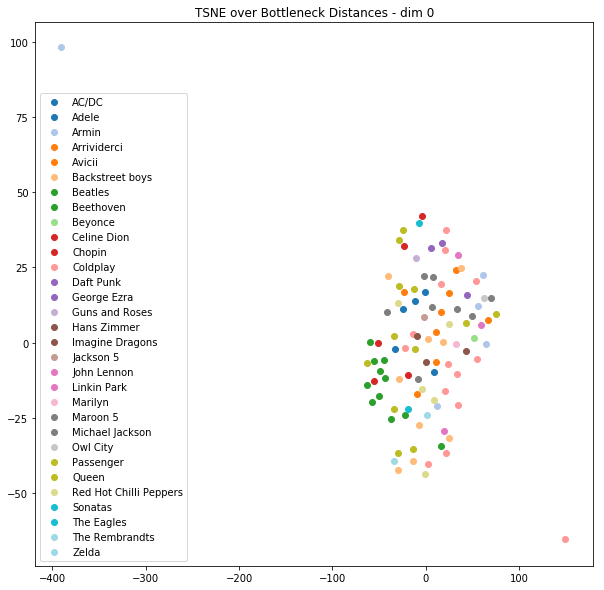

1


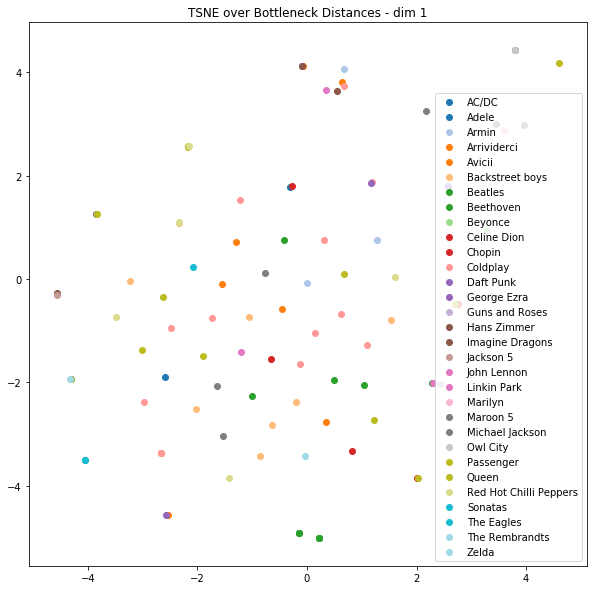

2


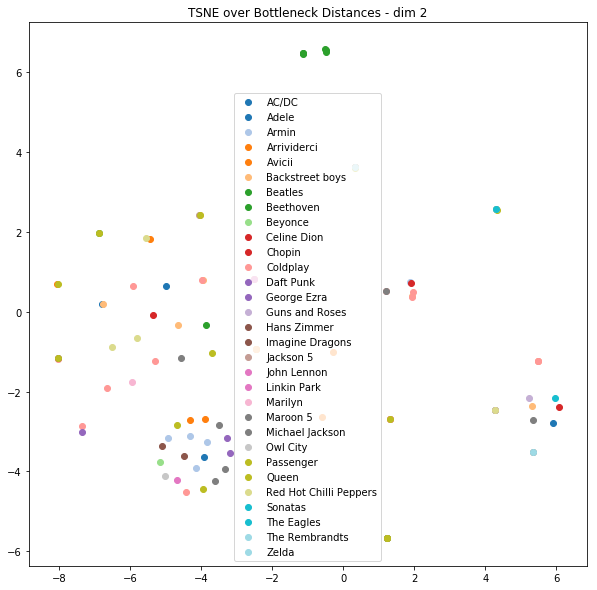

3


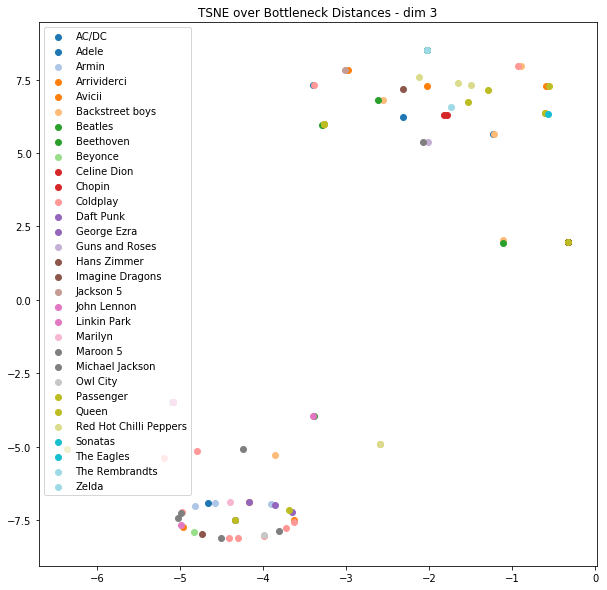

In [29]:
dim = 3

artists = np.array(songs_list['Artist'], dtype='str')

for j in range(dim+1):
    print(j)
    title = "TSNE over Bottleneck Distances - dim " + str(j)
    bottleneck_distances_TSNE = computeDimReduction('TSNE', bottleneck_distances[j])
    plotScatter(bottleneck_distances_TSNE, title, artists)

0


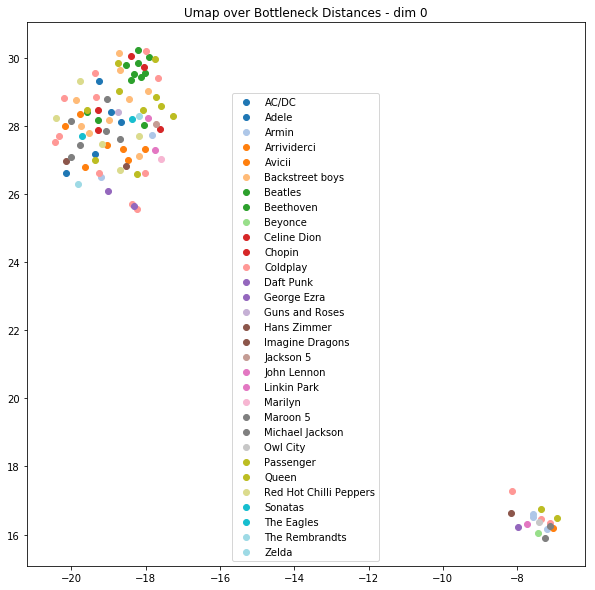

1


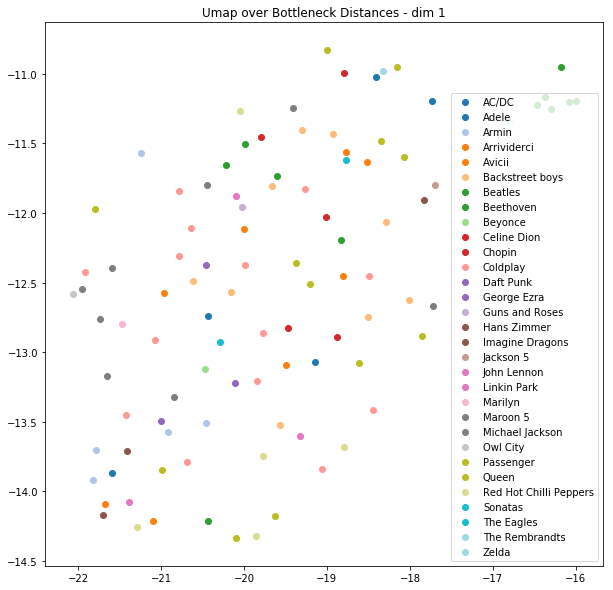

2


/home/yash/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


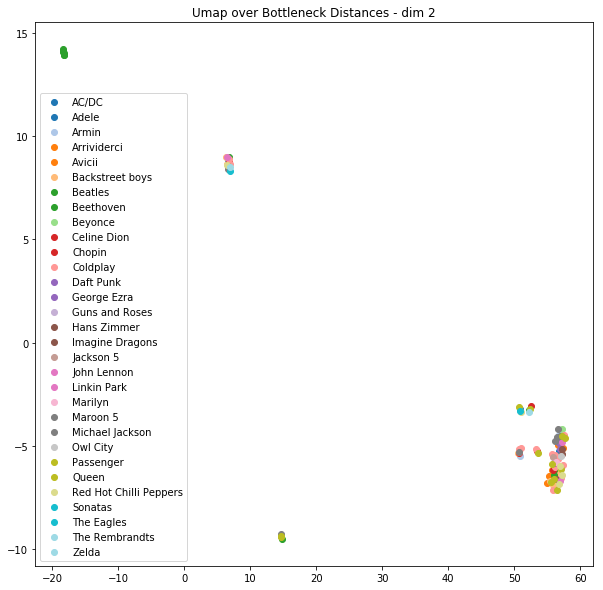

3


/home/yash/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components


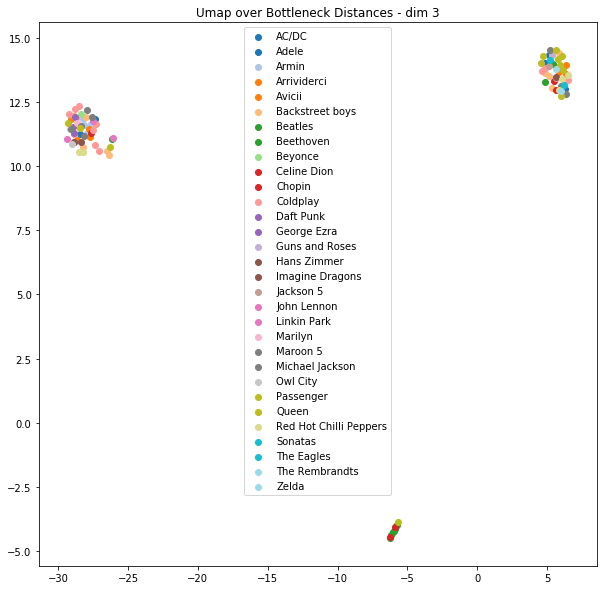

In [30]:
dim = 3

artists = np.array(songs_list['Artist'], dtype='str')

for j in range(dim+1):
    print(j)
    title = "Umap over Bottleneck Distances - dim " + str(j)
    bottleneck_distances_umap = computeDimReduction('umap', bottleneck_distances[j])
    plotScatter(bottleneck_distances_umap, title, artists)

0


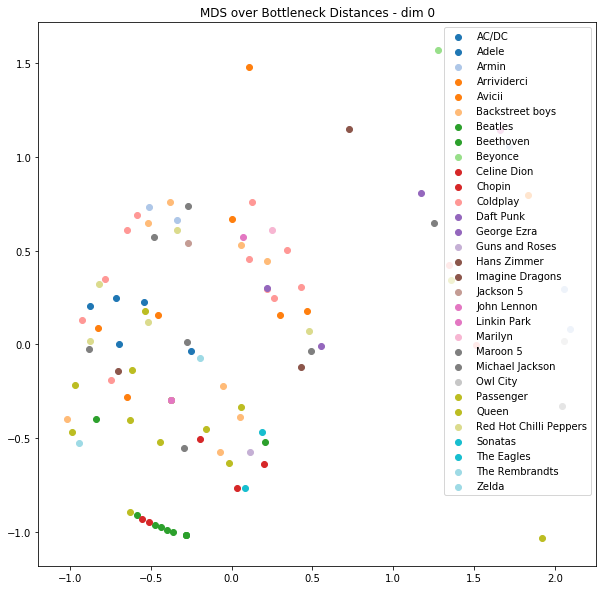

1


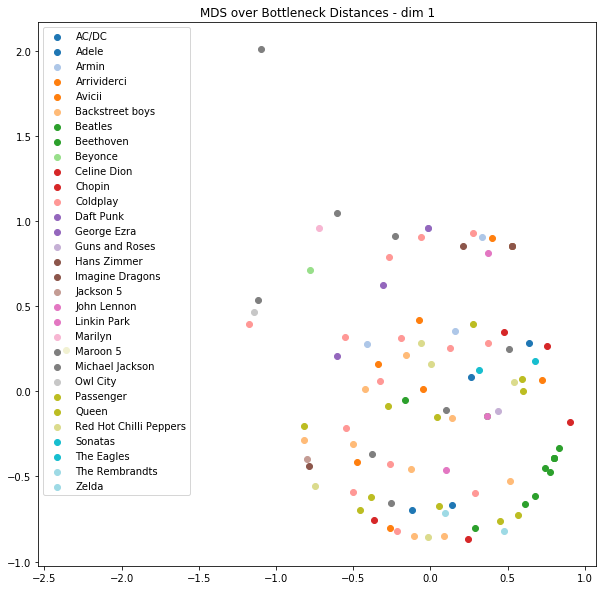

2


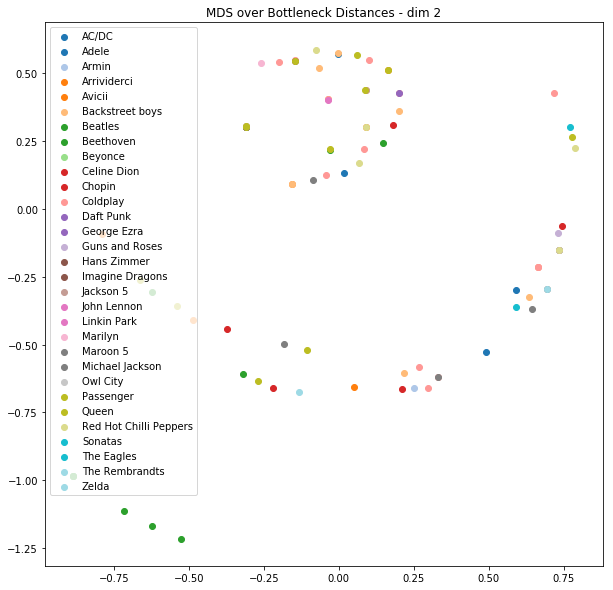

3


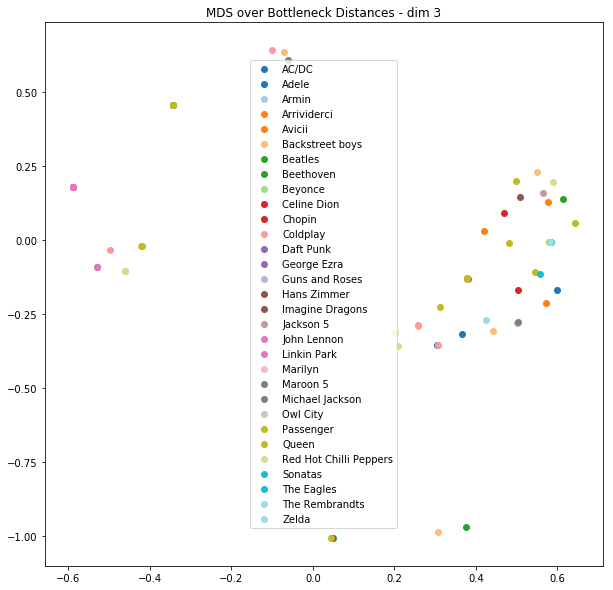

In [31]:
dim = 3

artists = np.array(songs_list['Artist'], dtype='str')

for j in range(dim+1):
    print(j)
    title = "MDS over Bottleneck Distances - dim " + str(j)
    bottleneck_distances_MDS = computeDimReduction('MDS', bottleneck_distances[j])
    plotScatter(bottleneck_distances_MDS, title, artists)

0


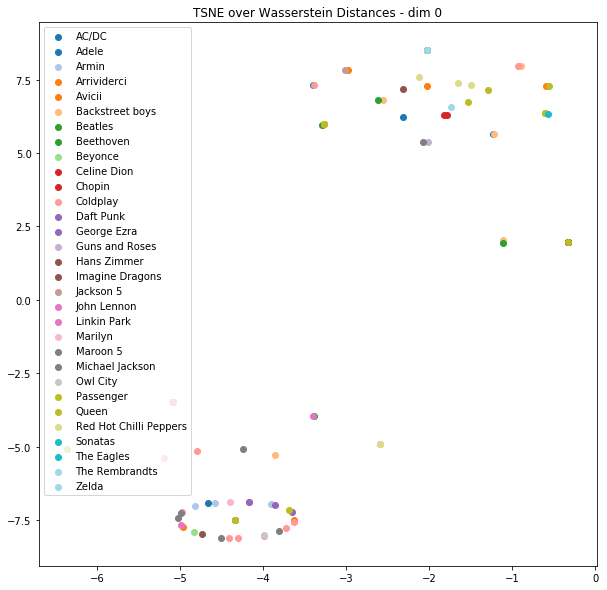

1


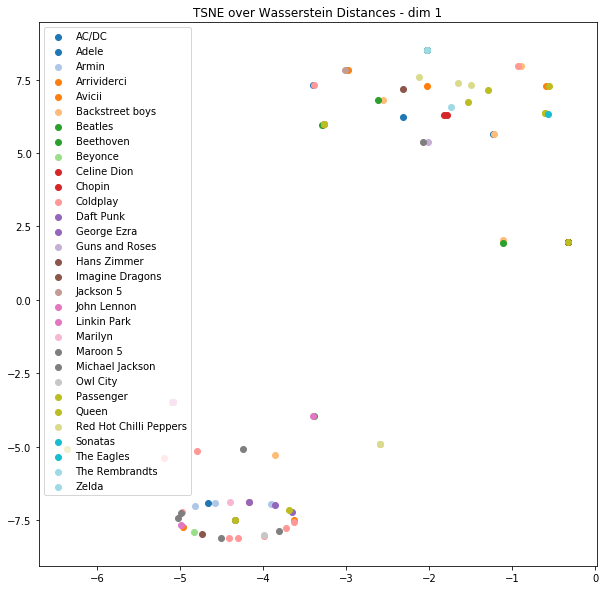

2


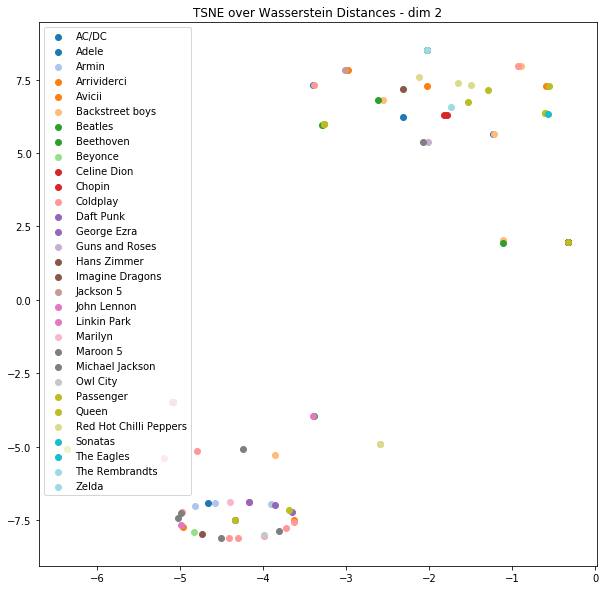

3


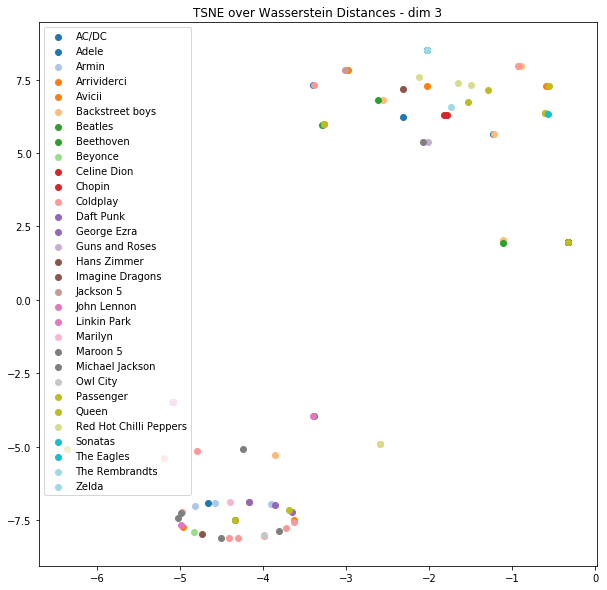

In [32]:
dim = 3
artists = np.array(songs_list['Artist'], dtype='str')
for j in range(dim+1):
    print(j)
    title = "TSNE over Wasserstein Distances - dim " + str(j)
    wassertian_distances_TSNE = computeDimReduction('TSNE', wassertian_distances[j])
    plotScatter(bottleneck_distances_TSNE, title, artists)

0


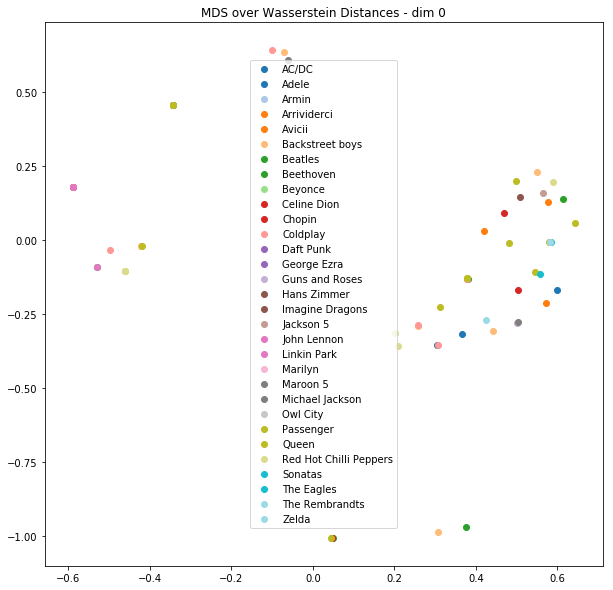

1


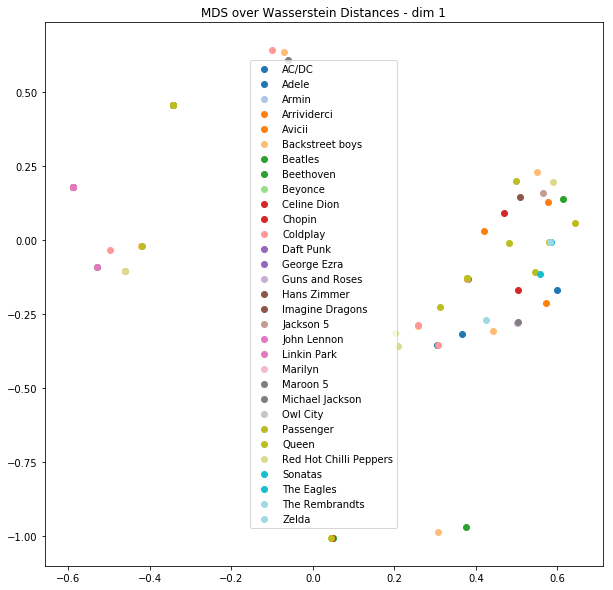

2


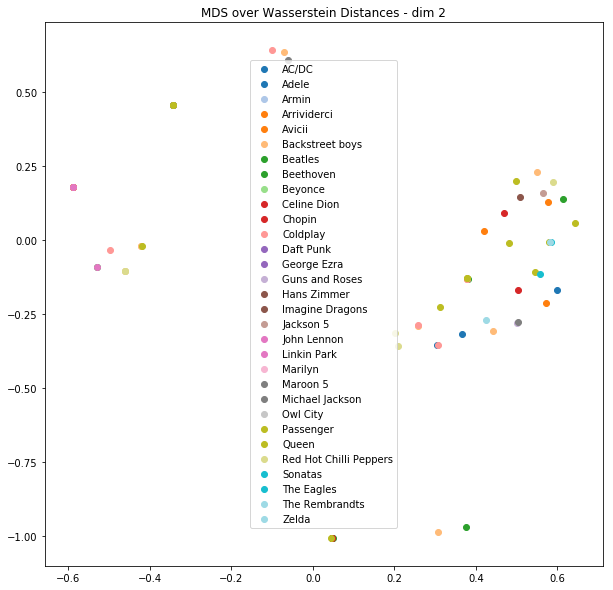

3


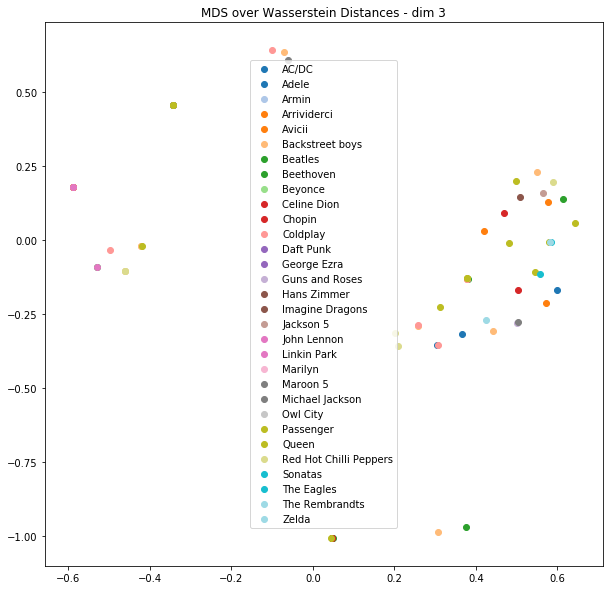

In [33]:
dim = 3
artists = np.array(songs_list['Artist'], dtype='str')
for j in range(dim+1):
    print(j)
    title = "MDS over Wasserstein Distances - dim " + str(j)
    wassertian_distances_MDS = computeDimReduction('MDS', wassertian_distances[j])
    plotScatter(bottleneck_distances_MDS, title, artists)

0


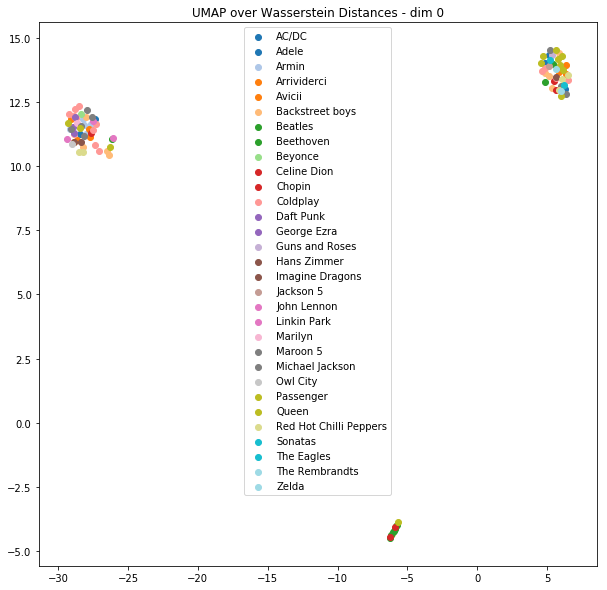

1


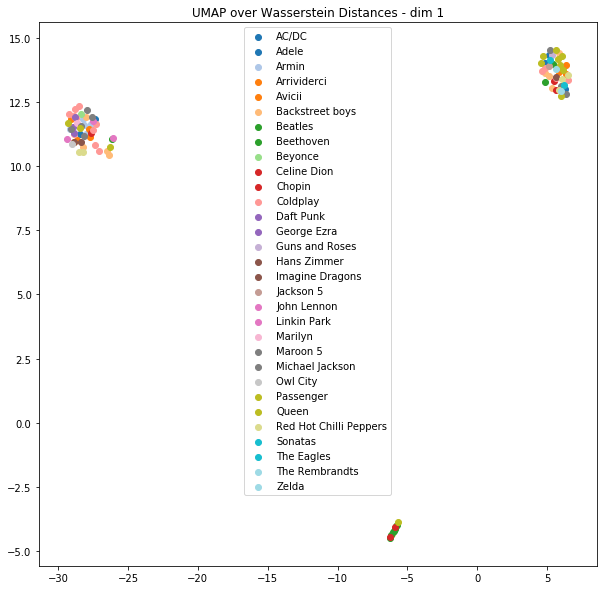

2


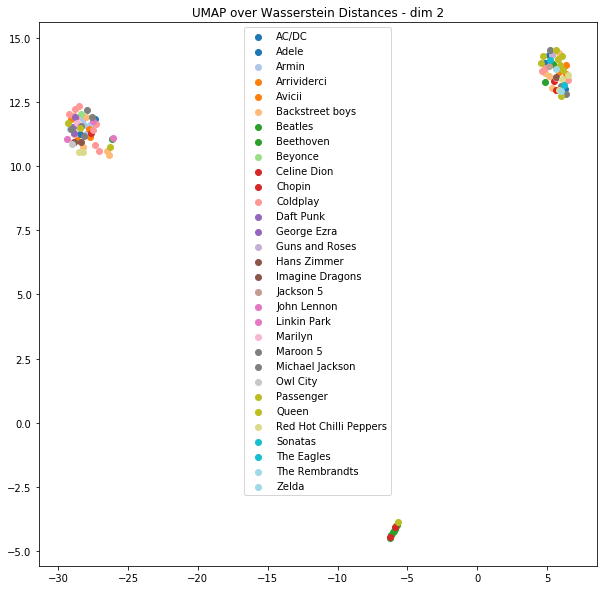

3


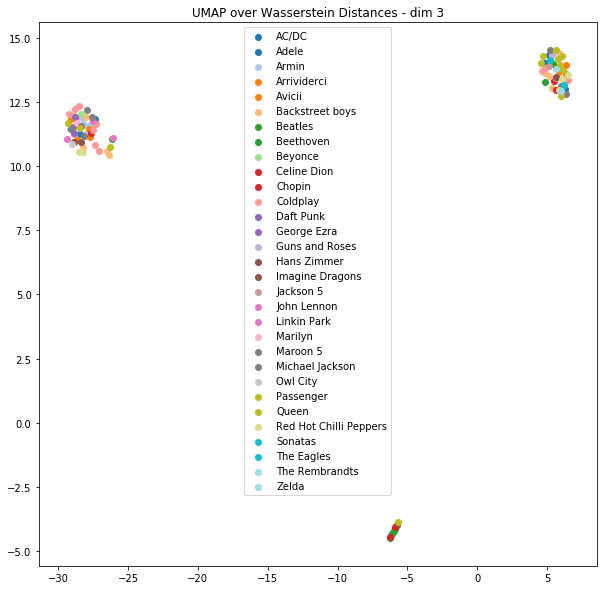

In [34]:
dim = 3
artists = np.array(songs_list['Artist'], dtype='str')
for j in range(dim+1):
    print(j)
    title = "UMAP over Wasserstein Distances - dim " + str(j)
    wassertian_distances_umap = computeDimReduction('umap', wassertian_distances[j])
    plotScatter(bottleneck_distances_umap, title, artists)

In [39]:
dim = 3
artists = np.array(songs_list['Artist'], dtype='str')
artists_uniq = np.unique(artists)

artists_labels = np.array([list(artists_uniq).index(artist) for artist in artists])

for j in range(dim+1):
    svc = SVC(kernel='precomputed')
    print(j)
    
    svc.fit(bottleneck_distances[j][
        np.array(songs_list['Split'], dtype='str') == 'R'
    ][
        :,np.array(songs_list['Split'], dtype='str') == 'R'
    ], artists_labels[np.array(songs_list['Split'], dtype='str') == 'R'])

    y_gt = artists_labels[np.array(songs_list['Split'], dtype='str') == 'E']
    
    y_pred = svc.predict(
        bottleneck_distances[j][
            np.array(songs_list['Split'], dtype='str') == 'E'
        ][
            :,np.array(songs_list['Split'], dtype='str') == 'R'
        ]
    )
    print(y_pred)
    print(y_gt)
    print(
        'Accuracy of SVM with bottleneck distances for dim {} features is {}'
        .format(j, np.sum(y_gt == y_pred) / len(y_gt))
    )

0
[ 7 11  7  7  7 11  7 11 11 11  7 11 11  7 11  7  7]
[25 25 11 11 11 26  5  5 10 22 22  7  7  4  0 24  2]
Accuracy of SVM with bottleneck distances for dim 0 features is 0.0
1
[ 7 11 11 11  7  7 11 11 11 11  7 11 11  7  7 11 11]
[25 25 11 11 11 26  5  5 10 22 22  7  7  4  0 24  2]
Accuracy of SVM with bottleneck distances for dim 1 features is 0.11764705882352941
2
[ 7  7  5  7  7  7  7  7  5 11  7  5  5  7  7  7  5]
[25 25 11 11 11 26  5  5 10 22 22  7  7  4  0 24  2]
Accuracy of SVM with bottleneck distances for dim 2 features is 0.0
3
[ 7  7  7  7  7  7  7 25  2  7  7  2  2  7  7  7  7]
[25 25 11 11 11 26  5  5 10 22 22  7  7  4  0 24  2]
Accuracy of SVM with bottleneck distances for dim 3 features is 0.0


In [40]:
dim = 3
artists = np.array(songs_list['Artist'], dtype='str')
artists_uniq = np.unique(artists)

artists_labels = np.array([list(artists_uniq).index(artist) for artist in artists])

for j in range(dim+1):
    svc = SVC(kernel='precomputed')
    print(j)
    
    svc.fit(wassertian_distances[j][
        np.array(songs_list['Split'], dtype='str') == 'R'
    ][
        :,np.array(songs_list['Split'], dtype='str') == 'R'
    ], artists_labels[np.array(songs_list['Split'], dtype='str') == 'R'])

    y_gt = artists_labels[np.array(songs_list['Split'], dtype='str') == 'E']
    
    y_pred = svc.predict(
        wassertian_distances[j][
            np.array(songs_list['Split'], dtype='str') == 'E'
        ][
            :,np.array(songs_list['Split'], dtype='str') == 'R'
        ]
    )
    print(y_pred)
    print(y_gt)
    print(
        'Accuracy of SVM with Wasserstein distances for dim {} features is {}'
        .format(j, np.sum(y_gt == y_pred) / len(y_gt))
    )

0
[ 7  7  7 11  7  7  7  5  5  7  7  5  5  7  7  7  7]
[25 25 11 11 11 26  5  5 10 22 22  7  7  4  0 24  2]
Accuracy of SVM with Wasserstein distances for dim 0 features is 0.11764705882352941
1
[ 7  7  7  7  7  7  7  7 11 11  7 11 11  7  7  7  7]
[25 25 11 11 11 26  5  5 10 22 22  7  7  4  0 24  2]
Accuracy of SVM with Wasserstein distances for dim 1 features is 0.0
2
[11  7  7 11  7  7  7  5  5  7 11  2  0 11 11 11  7]
[25 25 11 11 11 26  5  5 10 22 22  7  7  4  0 24  2]
Accuracy of SVM with Wasserstein distances for dim 2 features is 0.11764705882352941
3
[11  7 11 11 11  7 11 11 11  7 11 11 11 11 11 11 11]
[25 25 11 11 11 26  5  5 10 22 22  7  7  4  0 24  2]
Accuracy of SVM with Wasserstein distances for dim 3 features is 0.17647058823529413


In [41]:
dim = 3
genres = np.array(songs_list['Genre'], dtype='str')
genres_uniq = np.unique(genres)

genres_labels = np.array([list(genres_uniq).index(genre) for genre in genres])

for j in range(dim+1):
    svc = SVC(kernel='precomputed')
    print(j)
    
    svc.fit(bottleneck_distances[j][
        np.array(songs_list['Split'], dtype='str') == 'R'
    ][
        :,np.array(songs_list['Split'], dtype='str') == 'R'
    ], genres_labels[np.array(songs_list['Split'], dtype='str') == 'R'])

    y_gt = genres_labels[np.array(songs_list['Split'], dtype='str') == 'E']
    
    y_pred = svc.predict(
        bottleneck_distances[j][
            np.array(songs_list['Split'], dtype='str') == 'E'
        ][
            :,np.array(songs_list['Split'], dtype='str') == 'R'
        ]
    )
    print(y_pred)
    print(y_gt)
    print(
        'Accuracy of SVM with bottleneck distances for dim {} features is {}'
        .format(j, np.sum(y_gt == y_pred) / len(y_gt))
    )

0
[4 3 1 1 1 3 1 3 3 3 1 3 3 4 3 4 1]
[4 4 3 3 4 0 3 3 1 3 3 1 1 2 4 3 2]
Accuracy of SVM with bottleneck distances for dim 0 features is 0.17647058823529413
1
[4 3 3 3 4 1 3 3 3 3 4 3 3 4 4 3 3]
[4 4 3 3 4 0 3 3 1 3 3 1 1 2 4 3 2]
Accuracy of SVM with bottleneck distances for dim 1 features is 0.5294117647058824
2
[4 4 3 4 4 4 4 4 3 0 4 3 3 4 4 4 3]
[4 4 3 3 4 0 3 3 1 3 3 1 1 2 4 3 2]
Accuracy of SVM with bottleneck distances for dim 2 features is 0.29411764705882354
3
[4 3 4 4 4 3 4 3 3 3 4 3 3 4 4 4 4]
[4 4 3 3 4 0 3 3 1 3 3 1 1 2 4 3 2]
Accuracy of SVM with bottleneck distances for dim 3 features is 0.29411764705882354


In [42]:
dim = 3
genres = np.array(songs_list['Genre'], dtype='str')
genres_uniq = np.unique(genres)

genres_labels = np.array([list(genres_uniq).index(genre) for genre in genres])

for j in range(dim+1):
    svc = SVC(kernel='precomputed')
    print(j)
    
    svc.fit(wassertian_distances[j][
        np.array(songs_list['Split'], dtype='str') == 'R'
    ][
        :,np.array(songs_list['Split'], dtype='str') == 'R'
    ], genres_labels[np.array(songs_list['Split'], dtype='str') == 'R'])

    y_gt = genres_labels[np.array(songs_list['Split'], dtype='str') == 'E']
    
    y_pred = svc.predict(
        wassertian_distances[j][
            np.array(songs_list['Split'], dtype='str') == 'E'
        ][
            :,np.array(songs_list['Split'], dtype='str') == 'R'
        ]
    )
    print(y_pred)
    print(y_gt)
    print(
        'Accuracy of SVM with Wasserstein distances for dim {} features is {}'
        .format(j, np.sum(y_gt == y_pred) / len(y_gt))
    )

0
[4 3 4 4 4 3 4 3 3 3 4 3 3 4 4 4 4]
[4 4 3 3 4 0 3 3 1 3 3 1 1 2 4 3 2]
Accuracy of SVM with Wasserstein distances for dim 0 features is 0.29411764705882354
1
[4 3 1 1 4 1 1 3 0 3 4 0 0 4 4 4 4]
[4 4 3 3 4 0 3 3 1 3 3 1 1 2 4 3 2]
Accuracy of SVM with Wasserstein distances for dim 1 features is 0.29411764705882354
2
[1 1 1 3 1 1 1 3 3 3 1 3 3 1 1 1 1]
[4 4 3 3 4 0 3 3 1 3 3 1 1 2 4 3 2]
Accuracy of SVM with Wasserstein distances for dim 2 features is 0.17647058823529413
3
[4 1 4 4 4 1 4 4 4 1 4 4 4 4 4 4 4]
[4 4 3 3 4 0 3 3 1 3 3 1 1 2 4 3 2]
Accuracy of SVM with Wasserstein distances for dim 3 features is 0.17647058823529413


In [43]:
genres_uniq

array(['Alt Rock', 'Classical', 'EDM', 'Pop', 'Rock', 'nan'], dtype='<U64')

In [45]:
print(len(artists_uniq), artists_uniq)

31 ['AC/DC' 'Adele' 'Armin' 'Arrividerci' 'Avicii' 'Backstreet boys'
 'Beatles' 'Beethoven' 'Beyonce' 'Celine Dion' 'Chopin' 'Coldplay'
 'Daft Punk' 'George Ezra' 'Guns and Roses' 'Hans Zimmer'
 'Imagine Dragons' 'Jackson 5' 'John Lennon' 'Linkin Park' 'Marilyn'
 'Maroon 5' 'Michael Jackson' 'Owl City' 'Passenger' 'Queen'
 'Red Hot Chilli Peppers' 'Sonatas' 'The Eagles' 'The Rembrandts' 'Zelda']
